In [6]:
# ============================
# 0. Imports and global config
# ============================
import os
import cv2
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  

# ROI for capture / live Grad-CAM display
ROI_top, ROI_bottom, ROI_right, ROI_left = 100, 300, 350, 550

# Dataset / CV config (now supports digits + letters etc.)
RAW_DATASET_DIR        = 'dataset'              # live-captured raw images
PREPROCESSED_DIR       = 'dataset_preprocessed' # output of preprocessing


IMG_HEIGHT = 128
IMG_WIDTH  = 128
BATCH_SIZE = 32
NUM_CLASSES = 36      #  0-9 + A-Z 
EPOCHS = 20

# For preprocessing normalization 
MODEL_MEAN = np.array([0.485, 0.456, 0.406])
MODEL_STD  = np.array([0.229, 0.224, 0.225])

LAST_CONV_LAYER_NAME = "last_conv"


In [37]:
# ============================
# 1. Live capture (ROI)
# ============================
def capture_live_samples():
    cam = cv2.VideoCapture(0)
    # Now label can be digit or letter, e.g., '0'..'9', 'A'..'Z'
    element = input("Enter label (0-9 or A-Z): ").strip()
    save_dir = os.path.join(RAW_DATASET_DIR, element)
    os.makedirs(save_dir, exist_ok=True)

    while True:
        ret, frame = cam.read()
        if not ret:
            break
        frame = cv2.flip(frame, 1)
        clone = frame.copy()
        roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

        img_count = len([f for f in os.listdir(save_dir) if f.lower().endswith('.jpg')])

        cv2.rectangle(clone, (ROI_left, ROI_top), (ROI_right, ROI_bottom), (255,128,0), 3)
        cv2.putText(clone, f"Images Saved: {img_count}", (200, 400),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        cv2.putText(clone, "Press 's' to save, ESC to exit", (10, 20),
                    cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
        cv2.imshow("Sign Detection", clone)
        cv2.imshow("Raw Hand ROI", roi)

        k = cv2.waitKey(1) & 0xFF
        if k == ord('s'):
            cv2.imwrite(os.path.join(save_dir, f"{element}_{img_count}.jpg"), roi)
        if k == 27:
            break

    cam.release()
    cv2.destroyAllWindows()


In [39]:
capture_live_samples()    

Enter label (0-9 or A-Z):  2


In [8]:

# Data Preprocessing functions

def clahe_luminance(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

def deskew(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 25, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(cnt)
        angle = rect[-1]
        if angle < -45:
            angle += 90
        M = cv2.getRotationMatrix2D(rect[0], angle, 1.0)
        img = cv2.warpAffine(img, M, img.shape[1::-1],
                             flags=cv2.INTER_LINEAR, borderValue=(0, 0, 0))
    return img

def skin_mask(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower = np.array([0, 40, 60], dtype='uint8')
    upper = np.array([25, 200, 255], dtype='uint8')
    mask = cv2.inRange(hsv, lower, upper)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        img_roi = img[y:y+h, x:x+w]
        return mask, img_roi
    else:
        return mask, img

def letterbox_image(img, target_size):
    h, w = img.shape[:2]
    scale = min(target_size[0] / w, target_size[1] / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    top = (target_size[1] - new_h) // 2
    bottom = target_size[1] - new_h - top
    left = (target_size[0] - new_w) // 2
    right = target_size[0] - new_w - left
    return cv2.copyMakeBorder(resized, top, bottom, left, right,
                              cv2.BORDER_CONSTANT, value=[0, 0, 0])

def augment_image(img):
    if random.random() < 0.5:
        img = cv2.flip(img, 1)
    angle = random.uniform(-18, 18)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)
    if random.random() < 0.5:
        alpha = random.uniform(0.85, 1.15)
        beta = random.randint(-18, 18)
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    if random.random() < 0.25:
        k = random.choice([3, 5])
        img = cv2.GaussianBlur(img, (k, k), 0)
    return img

def preprocess_sign_image(img_path, do_augment=False):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = deskew(img)
    _, hand_roi = skin_mask(img)
    if do_augment:
        hand_roi = augment_image(hand_roi)
    img_boxed = letterbox_image(hand_roi, (IMG_WIDTH, IMG_HEIGHT))
    if np.std(img_boxed) > 12:
        img_boxed = cv2.bilateralFilter(img_boxed, 5, 15, 15)
    img_boxed = clahe_luminance(img_boxed)
    img_float = img_boxed.astype(np.float32) / 255.0
    img_standard = (img_float - MODEL_MEAN) / MODEL_STD
    out_img = (np.clip((img_standard * MODEL_STD + MODEL_MEAN), 0, 1) * 255).astype(np.uint8)
    out_img = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
    return out_img

def process_dataset(input_root=RAW_DATASET_DIR, output_root=PREPROCESSED_DIR, n_aug=2):
    for subdir, dirs, files in os.walk(input_root):
        rel_path = os.path.relpath(subdir, input_root)
        save_subdir = os.path.join(output_root, rel_path)
        os.makedirs(save_subdir, exist_ok=True)
        jpg_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for f in tqdm(jpg_files, desc=f"Processing {rel_path}"):
            in_image = os.path.join(subdir, f)
            base, ext = os.path.splitext(f)
            processed_img = preprocess_sign_image(in_image, do_augment=False)
            cv2.imwrite(os.path.join(save_subdir, f"{base}_orig{ext}"), processed_img)
            for i in range(1, n_aug):
                aug_img = preprocess_sign_image(in_image, do_augment=True)
                cv2.imwrite(os.path.join(save_subdir, f"{base}_aug{i}{ext}"), aug_img)
    print(f"All images processed and saved in {output_root}.")



In [10]:
process_dataset()          # dataset -> dataset_preprocessed

Processing .: 0it [00:00, ?it/s]
Processing z: 100%|██████████| 70/70 [00:02<00:00, 31.13it/s]

All images processed and saved in dataset_preprocessed_v5.


In [11]:
#  train/test split


def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

TRAIN_TEST_SPLIT_DIR = "dataset_split_v5"  
TEST_RATIO = 0.2                       

def split_train_test(class_folder, class_name, test_ratio=TEST_RATIO):
    images = [img for img in os.listdir(class_folder)
              if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    random.shuffle(images)
    n = len(images)
    test_size = int(n * test_ratio)

    test_files  = images[:test_size]
    train_files = images[test_size:]

    splits = [
        ('train', train_files),
        ('test',  test_files)
    ]

    for split_name, file_list in splits:
        split_dir = os.path.join(TRAIN_TEST_SPLIT_DIR, split_name, class_name)
        ensure_dir(split_dir)
        for fname in file_list:
            src = os.path.join(class_folder, fname)
            dst = os.path.join(split_dir, fname)
            shutil.copy2(src, dst)

def create_train_test_split():
    for class_name in os.listdir(PREPROCESSED_DIR):
        class_folder = os.path.join(PREPROCESSED_DIR, class_name)

        if os.path.isdir(class_folder):
            print(f"Processing class '{class_name}'...")
            split_train_test(class_folder, class_name, TEST_RATIO)

    print(f"Train/Test split created in '{TRAIN_TEST_SPLIT_DIR}'.")


In [14]:
create_train_test_split()      

Processing class '0'...
Processing class '1'...
Processing class '2'...
Processing class '3'...
Processing class '4'...
Processing class '5'...
Processing class '6'...
Processing class '7'...
Processing class '8'...
Processing class '9'...
Processing class 'a'...
Processing class 'b'...
Processing class 'c'...
Processing class 'd'...
Processing class 'e'...
Processing class 'f'...
Processing class 'g'...
Processing class 'h'...
Processing class 'i'...
Processing class 'j'...
Processing class 'k'...
Processing class 'l'...
Processing class 'm'...
Processing class 'n'...
Processing class 'o'...
Processing class 'p'...
Processing class 'q'...
Processing class 'r'...
Processing class 's'...
Processing class 't'...
Processing class 'u'...
Processing class 'v'...
Processing class 'w'...
Processing class 'x'...
Processing class 'y'...
Processing class 'z'...
Train/Test split created in 'dataset_split_v5'.


Found 28214 images belonging to 36 classes.
Found 7050 images belonging to 36 classes.


C:\Users\mamid\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
Epoch 1: Test Acc = 0.3502, Test Loss = 1.9939
882/882 - 721s - 818ms/step - accuracy: 0.2401 - loss: 2.5662
Epoch 2/30
Epoch 2: Test Acc = 0.6274, Test Loss = 1.1582
882/882 - 267s - 303ms/step - accuracy: 0.4994 - loss: 1.5710
Epoch 3/30
Epoch 3: Test Acc = 0.7217, Test Loss = 0.8710
882/882 - 265s - 301ms/step - accuracy: 0.6520 - loss: 1.0786
Epoch 4/30
Epoch 4: Test Acc = 0.7943, Test Loss = 0.6545
882/882 - 279s - 316ms/step - accuracy: 0.7342 - loss: 0.8328
Epoch 5/30
Epoch 5: Test Acc = 0.8024, Test Loss = 0.6375
882/882 - 303s - 343ms/step - accuracy: 0.7779 - loss: 0.6850
Epoch 6/30
Epoch 6: Test Acc = 0.8346, Test Loss = 0.5135
882/882 - 277s - 314ms/step - accuracy: 0.8135 - loss: 0.5836
Epoch 7/30
Epoch 7: Test Acc = 0.8250, Test Loss = 0.5613
882/882 - 269s - 305ms/step - accuracy: 0.8318 - loss: 0.5246
Epoch 8/30
Epoch 8: Test Acc = 0.8523, Test Loss = 0.4861
882/882 - 270s - 306ms/step - accuracy: 0.8516 - loss: 0.4648
Epoch 9/30
Epoch 9: Test Acc = 0.9074, T

Model saved at: saved_models_v5/final_model_sign_language.h5

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       630
           1       0.96      0.95      0.95       638
           2       0.91      0.95      0.93       652
           3       0.99      0.89      0.94       636
           4       0.97      0.93      0.95       628
           5       0.95      0.99      0.97       628
           6       0.88      0.96      0.92       628
           7       0.93      0.96      0.94       628
           8       0.95      0.95      0.95       628
           9       0.98      0.96      0.97       628
           a       0.86      0.86      0.86        28
           b       0.88      1.00      0.93        28
           c       0.96      0.96      0.96        28
           d       1.00      0.82      0.90        28
           e       0.77      0.96      0.86        28
           f       0.91      0.71      0.80       

<Figure size 1200x1000 with 0 Axes>

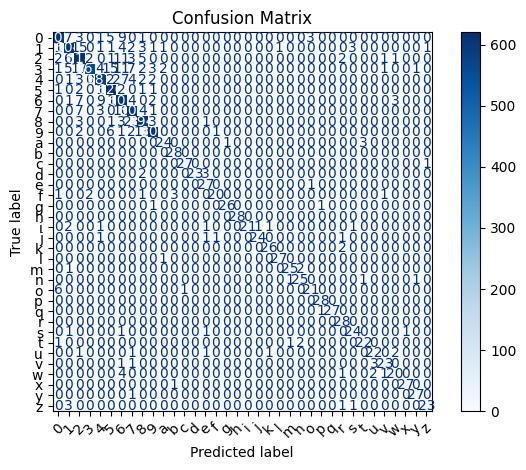

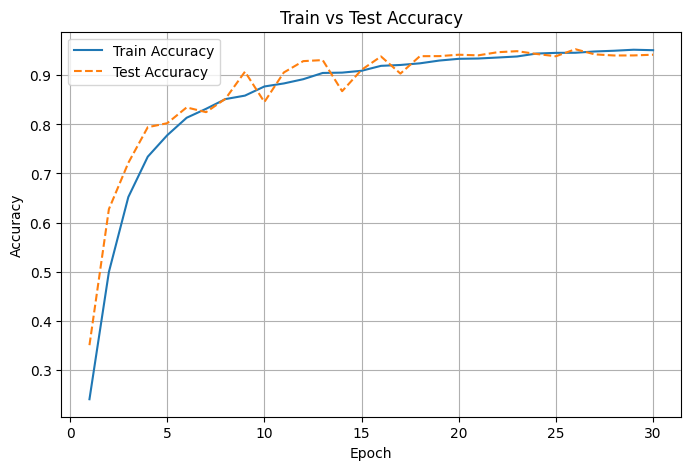

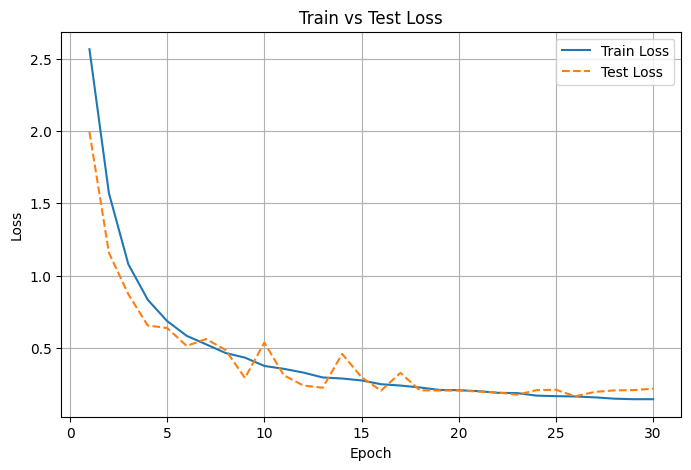

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report


# Configuration

ROOT_DIR   = "dataset_split"  
IMG_SIZE   = (128, 128)
BATCH_SIZE = 32
EPOCHS     = 30

# Directory for saving models
os.makedirs("saved_model", exist_ok=True)


# Data Generators with Augmentation

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

eval_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)

train_path = f"{ROOT_DIR}/train"
test_path  = f"{ROOT_DIR}/test"

train_batches = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_batches = eval_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

num_classes = train_batches.num_classes


# Building CNN Model

def build_model(num_classes):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input, BatchNormalization

    model = Sequential([
        Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

        Conv2D(32, (3,3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPool2D((2,2)),

        Conv2D(64, (3,3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPool2D((2,2)),

        Conv2D(128, (3,3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPool2D((2,2)),

        Conv2D(256, (3,3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPool2D((2,2)),

        Flatten(),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_model(num_classes)


# Custom Callback for Test Metrics

class TestMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        super().__init__()
        self.test_data = test_data
        self.test_acc_per_epoch = []
        self.test_loss_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(self.test_data, verbose=0)
        self.test_acc_per_epoch.append(acc)
        self.test_loss_per_epoch.append(loss)
        print(f"Epoch {epoch+1}: Test Acc = {acc:.4f}, Test Loss = {loss:.4f}")

test_callback = TestMetricsCallback(test_batches)


# Early Stopping 

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    patience=4,
    restore_best_weights=True
)


# Train Model 

history = model.fit(
    train_batches,
    validation_data=test_batches,
    epochs=EPOCHS,
    verbose=2,
    callbacks=[test_callback, early_stop]
)


# Save Model

model_path = "saved_model/final_model_sign_language.h5"
model.save(model_path)
print(f"Model saved at: {model_path}")


# Classification Report
y_pred = model.predict(test_batches, verbose=0)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = test_batches.classes
target_names = list(test_batches.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels, target_names=target_names))


# Confusion Matrix

cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(12,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(xticks_rotation=45, cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Plot Train and Test Accuracy & Loss

train_acc  = history.history["accuracy"]
train_loss = history.history["loss"]
test_acc   = test_callback.test_acc_per_epoch
test_loss  = test_callback.test_loss_per_epoch

epochs_range = range(1, len(train_acc)+1)

# Accuracy Plot
plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_acc, label="Train Accuracy")
plt.plot(epochs_range, test_acc, label="Test Accuracy", linestyle="dashed")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.plot(epochs_range, test_loss, label="Test Loss", linestyle="dashed")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
pip install mediapipe opencv-python tensorflow


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from pathlib import Path


# 1. FIX FILE PATH AND LOAD MODEL

home_dir = Path.home()  
model_path = home_dir / "OneDrive" / "Desktop" / "Sign_language_prediction" / "saved_models_v5" / "final_model_sign_language.h5"

print(f"Looking for model at: {model_path}")

if not model_path.exists():
    print(f"\n❌ Model file not found: {model_path}")
    exit()

# Load model
try:
    model = tf.keras.models.load_model(str(model_path))
    print(f"✓ Loaded model: {model_path.name}")
except Exception as e:
    print(f"✗ Error loading model: {e}")
    exit()


# 2. AUTO-DETECT NUMBER OF CLASSES

num_classes = model.output_shape[1]
print(f"\nModel output shape: {model.output_shape}")
print(f"Number of classes detected: {num_classes}")

# Create class labels
if num_classes == 36:
    class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 
                    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 
                    'U', 'V', 'W', 'X', 'Y', 'Z']
elif num_classes == 26:
    class_labels = [chr(i) for i in range(65, 91)]  # A-Z
elif num_classes == 10:
    class_labels = [str(i) for i in range(10)]
else:
    print(f"⚠️ Using numeric class IDs (0-{num_classes-1})")
    class_labels = [str(i) for i in range(num_classes)]

print(f"Class labels ({len(class_labels)} total): {class_labels}")


# 3. MEDIAPIPE SETUP

mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils


# 4. PREDICTION FUNCTION

def predict(model, roi, class_labels):
    if roi is None or roi.size == 0:
        return None, None, None

    try:
        img = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_LINEAR)
        img = img.astype("float32") / 255.0
        img = np.expand_dims(img, axis=0)  

        preds = model.predict(img, verbose=0)[0]
        class_id = int(np.argmax(preds))
        confidence = float(preds[class_id])

        label = class_labels[class_id] if class_id < len(class_labels) else str(class_id)
        return label, class_id, confidence
    except Exception as e:
        print(f"Prediction Error: {e}")
        return None, None, None


# 5. EXTRACT ROI FROM HAND

def extract_hand_roi(frame, hand_landmarks, margin=30):
    h, w, _ = frame.shape
    x_coords = [lm.x * w for lm in hand_landmarks.landmark]
    y_coords = [lm.y * h for lm in hand_landmarks.landmark]
    
    x_min = max(0, int(min(x_coords)) - margin)
    x_max = min(w, int(max(x_coords)) + margin)
    y_min = max(0, int(min(y_coords)) - margin)
    y_max = min(h, int(max(y_coords)) + margin)
    
    roi = frame[y_min:y_max, x_min:x_max]
    return roi, (x_min, y_min, x_max, y_max)


# 6. MAIN LIVE DETECTION LOOP

def main():
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=1,
        min_detection_confidence=0.7,
        min_tracking_confidence=0.5
    ) as hands:
        
        print("\n=================================")
        print("Starting live detection...")
        print(f"Detecting: {len(class_labels)} classes")
        print("Press 'q' to quit")
        print("=================================\n")
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                print("Failed to grab frame")
                break
            
            frame = cv2.flip(frame, 1)
            h, w, _ = frame.shape
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(rgb_frame)
            
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    mp_draw.draw_landmarks(
                        frame, 
                        hand_landmarks, 
                        mp_hands.HAND_CONNECTIONS,
                        mp_draw.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                        mp_draw.DrawingSpec(color=(255, 255, 255), thickness=2)
                    )
                    
                    roi, (x_min, y_min, x_max, y_max) = extract_hand_roi(frame, hand_landmarks)
                    cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                    
                    label, class_id, confidence = predict(model, roi, class_labels)
                    
                    if label is not None and confidence > 0.5:
                        text = f"{label}: {confidence:.2f}"
                        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)[0]
                        cv2.rectangle(frame, 
                                      (x_min, y_min - text_size[1] - 15), 
                                      (x_min + text_size[0], y_min - 5),
                                      (0, 255, 0), -1)
                        cv2.putText(frame, text, (x_min, y_min - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                    elif label is not None:
                        text = f"{label}: {confidence:.2f}"
                        cv2.putText(frame, text, (x_min, y_min - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
            else:
                cv2.putText(frame, "Show your hand sign", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            
            cv2.putText(frame, "Press 'q' to quit", (10, h - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            cv2.imshow('Sign Language Detection', frame)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        cap.release()
        cv2.destroyAllWindows()
        print("\nDetection stopped")


# 7. RUN THE APPLICATION

if __name__ == "__main__":
    main()
